In [1]:
using ReinforcementLearning
using Flux
using Flux.Losses
using IntervalSets
using StableRNGs
using Plots
# using CUDA
# using ControlSystems
using FurutaPendulums
using BSON

[ Info: Precompiling FurutaPendulums [8f95568d-7bec-4a61-b2a3-e2d98ddd1432]


In [2]:
JULIA_NUM_THREADS = 16

16

Environment Architecture

In [36]:
mutable struct FurutaEnv <: AbstractEnv
    state
    reward::AbstractFloat
    action_space
    state_space
    done
    furuta
    t
    dt
    tmax
    last_time
end

function FurutaEnv(;
        max_u=5.,
        max_dθ=100.,
        max_dϕ=100.,
        dt = 0.01,
        tmax = 5.
        )
    high = [2pi,max_dθ,2pi,max_dϕ]
    low = [0,-max_dθ,0,-max_dϕ]
    furuta = SimulatedFurutaPendulum()
    
    FurutaEnv(
        measure(furuta)[2:4],
        0.,
        ClosedInterval.(-max_u,max_u),
        Space(ClosedInterval{Float64}.(low, high)),
        false,
        furuta,
        0.,
        dt,
        tmax,
        0.
        )
end

RLBase.action_space(env::FurutaEnv) = env.action_space
RLBase.state_space(env::FurutaEnv) = env.state_space
function RLBase.reward(env::FurutaEnv)
    env.reward = cos(env.state[2]) - abs(0.01*env.state[1]^2) #-abs(1 - cos(env.state[2]) - 0.0021 * env.state[3]^2) - abs(0.001 * env.state[1]^2)
end
RLBase.is_terminated(env::FurutaEnv) = env.done
RLBase.state(env::FurutaEnv) = measure(env.furuta)[2:4]

function (env::FurutaEnv)(a::AbstractFloat)
    control(env.furuta,a)
    env.last_time = periodic_wait(env.furuta,env.last_time,env.dt)
    env.state[:] = measure(env.furuta)[2:4]
    env.t += env.dt
    env.done = env.t >= env.tmax
end

function RLBase.reset!(env::FurutaEnv)
    env.last_time = 0.
    env.reward = 0.
    env.t = 0.
    env.furuta = SimulatedFurutaPendulum()
    env.state = measure(env.furuta)[2:4]
    env.done = false
end

3-element Vector{Float64}:
 0.0
 3.141592653589793
 0.0

## Test your environment

In [40]:
run(
           RandomPolicy(),
         #   ex.policy,
          #  model,
           FurutaEnv(),
           StopAfterEpisode(10),
           TotalRewardPerEpisode()
       )

               ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
               ┌────────────────────────────────────────┐ 
         -2200 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠃⢇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡎⠀⠘⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⢣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡜⠀⠀⠀⢱⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠸⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡰⠁⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⢇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠃⠀⠀⠀⠀⠀⠸⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡠⢲⠀⠀⠀⠀│ 
               │⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡎⠀⠀⠀⠀⠀⠀⠀⢣⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⠔⠉⠀⠈⡆⠀⠀⠀│ 
   Score       │⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⡸⠀⠀⠀⠀⠀⠀⠀⠀⠈⡆⠀⠀⠀⠀⠀⠀⠀⢰⠁⠀⠀⠀⠀⢸⠀⠀⠀│ 
               │⠀⠀⢱⠀⠀⠀⠀⠀⠀⠀⠀⢰⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠸⡀⠀⠀⠀⠀⠀⢀⠇⠀⠀⠀⠀⠀⠀⡇⠀⠀│ 
               │⠀⠀⠈⡆⠀⠀⠀⠀⠀⠀⢀⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢣⠀⠀⠀⠀⠀⡸⠀⠀⠀⠀⠀⠀⠀⠸⡀⠀│ 
               │⠀⠀⠀⢣⠀⠀⠀⠀⠀⠀⡜⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⡆⠀⠀⠀⢠⠃⠀⠀⠀⠀⠀⠀⠀⠀⢇⠀│ 
               │⠀⠀⠀⠘⡄⠀⠀⠀⠀⡸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠸⡀⠀⠀⡎⠀⠀⠀⠀⠀⠀⠀⠀⠀⠸⡀│ 
               │⠀⠀⠀⠀⠧⠤⠤⠤⠤⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢣⠀⢰⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢣│ 
               │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⣆⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘│ 
         -2700 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

TotalRewardPerEpisode([-2282.9320191883908, -2623.8599771830545, -2618.4670787252735, -2415.170859300062, -2223.1462360166697, -2454.792461112721, -2677.280736780076, -2432.570237912577, -2376.1507808361694, -2645.083512192182], 0.0, true)

## Train a new model

# Play Pendulum with TD3


Progress: 100%|█████████████████████████████████████████| Time: 0:07:05


               ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
               ┌────────────────────────────────────────┐ 
          1000 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⠀⣀⣀⠀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀│ 
               │⠀⠀⠀⠀⠀⠀⡀⠀⢸⣶⣿⣿⣿⣿⢿⡿⠛⠿⠛⠿⢿⢿⠿⠿⠿⡿⠛⠻⢿⠟⠿⠟⠛⠻⠛⠿⠛⠟⠛⠛│ 
               │⣀⣀⣶⣿⣷⣾⣿⣾⣿⣹⣿⣿⣇⣁⣈⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣈⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀│ 
               │⢸⣼⡟⠟⠋⠉⠘⢻⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⣿⠿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
   Score       │⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -3000 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

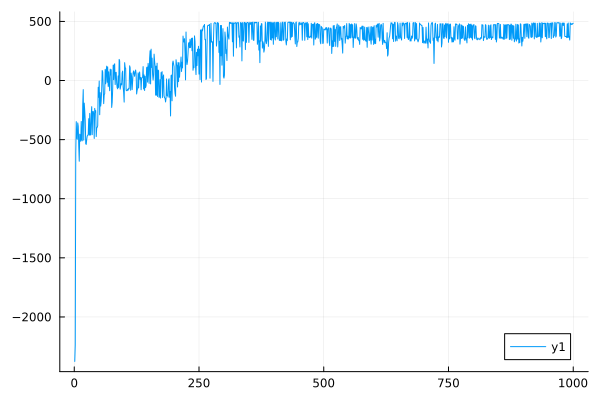

In [37]:
function RL.Experiment(
    ::Val{:JuliaRL},
    ::Val{:TD3},
    ::Val{:Pendulum},
    ::Nothing;
    seed = 123,
)
    rng = StableRNG(seed)
    env = FurutaEnv()
    A = action_space(env)
    ns = length(state(env))
    init = glorot_uniform(rng)

    create_actor() = Chain(
        Dense(ns, 32, relu; init = init),
        Dense(32, 32, relu; init = init),
        Dense(32, 1, tanh; init = init),
    ) |> cpu

    create_critic_model() = Chain(
        Dense(ns + 1, 32, relu; init = init),
        Dense(32, 32, relu; init = init),
        Dense(32, 1; init = init),
    ) |> cpu

    create_critic() = TD3Critic(create_critic_model(), create_critic_model())

    agent = Agent(
        policy = TD3Policy(
            behavior_actor = NeuralNetworkApproximator(
                model = create_actor(),
                optimizer = ADAM(),
            ),
            behavior_critic = NeuralNetworkApproximator(
                model = create_critic(),
                optimizer = ADAM(),
            ),
            target_actor = NeuralNetworkApproximator(
                model = create_actor(),
                optimizer = ADAM(),
            ),
            target_critic = NeuralNetworkApproximator(
                model = create_critic(),
                optimizer = ADAM(),
            ),
            γ = 0.99f0,
            ρ = 0.99f0,
            batch_size = 64,
            start_steps = 1000,
            start_policy = RandomPolicy(-5.0..5.0; rng = rng),
            update_after = 1000,
            update_freq = 1,
            policy_freq = 2,
            target_act_limit = 5.0,
            target_act_noise = 0.1,
            act_limit = 5.0,
            act_noise = 0.1,
            rng = rng,
        ),
        trajectory = CircularArraySARTTrajectory(
            capacity = 1_000_000,
            state = Vector{Float32} => (ns,),
            action = Float32 => (),
        ),
    )

    #stop_condition = StopAfterStep(10000, is_show_progress=!haskey(ENV, "CI"))
    stop_condition = StopAfterEpisode(1000; cur = 0, is_show_progress = true)
    hook = TotalRewardPerEpisode() 
    Experiment(agent, env, stop_condition, hook, "# Play Pendulum with TD3")
end

ex = E`JuliaRL_TD3_Pendulum`
run(ex)
plot(ex.hook.rewards)

## Continue training the previous model for more episodes

# Play Pendulum with TD3


Progress: 100%|█████████████████████████████████████████| Time: 0:01:21


              ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
              ┌────────────────────────────────────────┐ 
            0 │⠀⠀⠀⠀⠀⠀⠀⡀⠀⢰⠛⡗⣶⣶⡇⡇⣷⢸⣿⣿⢸⣿⢸⡗⣶⣿⣧⡆⡔⡶⣤⣰⠀⢰⣄⠀⠀⠀⡄⣦│ 
              │⢀⡀⠀⢀⡄⣆⣴⣿⣿⢸⠀⡇⣿⣿⡇⣇⣿⢸⣿⣿⢸⣿⢸⡇⣿⣿⣿⡇⡇⡇⣿⣿⢠⣾⣿⠀⢠⣦⡇⣿│ 
              │⡟⡇⣷⣾⡇⣿⣿⣿⣿⢸⠀⡇⣿⣿⢱⣿⣿⢸⣿⣿⢸⣿⣾⡇⣿⣿⣿⢱⡇⡇⢸⣿⢸⣿⣿⠀⢸⣿⣷⣿│ 
              │⠀⢣⣿⣿⢱⣿⣿⣿⣿⡜⠀⠃⠻⠻⢸⠛⢻⢺⠹⣿⡞⡟⡿⡇⢻⠉⣿⢸⠇⡇⠸⠿⣾⡿⡿⡀⢸⣿⣿⣿│ 
              │⠀⢸⣿⣿⢸⡏⢻⠃⠁⠀⠀⠀⠀⠀⠘⠀⠀⠀⠀⢸⡇⠀⠁⠀⠀⠀⠸⠀⠀⠁⠀⠀⡇⠀⠁⢳⣼⢿⠉⠙│ 
              │⠀⢸⠋⠛⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠈⠟⠀⠀⠀│ 
              │⠀⢸⠀⠀⢸⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀│ 
   Score      │⠀⠸⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠃⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -300 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              

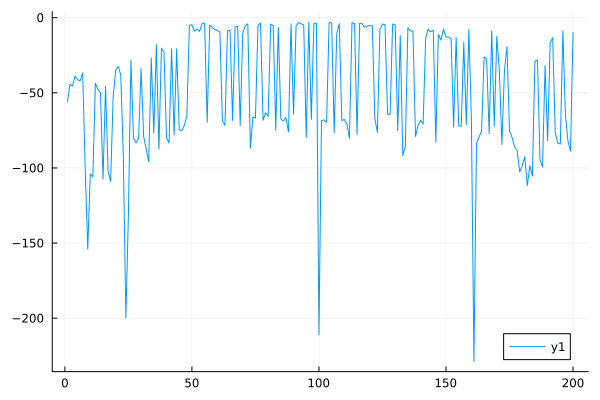

In [27]:
function RL.Experiment(
    ::Val{:JuliaRL},
    ::Val{:TD3},
    ::Val{:Pendulum},
    ::Nothing;
    seed = 123,
)
    env = FurutaEnv()
    agent = ex.policy

    stop_condition = StopAfterEpisode(200; cur = 0, is_show_progress = true)
    hook = TotalRewardPerEpisode()
    Experiment(agent, env, stop_condition, hook, "# Play Pendulum with TD3")
end

ex = E`JuliaRL_TD3_Pendulum`
run(ex)
plot(ex.hook.rewards)

## Test your model

[ Info: Saved animation to c:\Users\Hashim\group-2\unfinished\anim_pendulum.gif


Plots.AnimatedGif("c:\\Users\\Hashim\\group-2\\unfinished\\anim_pendulum.gif")
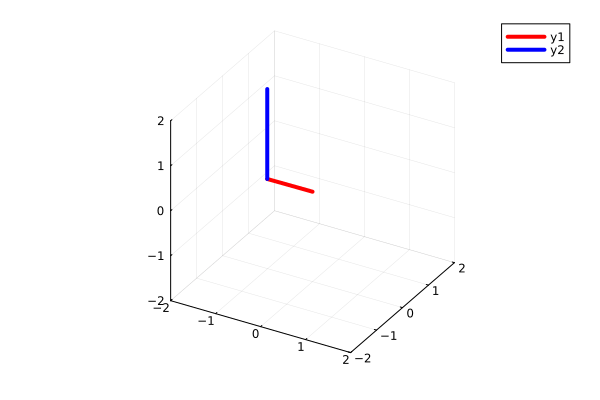

In [38]:
include("../src/sim/env.jl")

env = FurutaEnv()
tmax = 20.
tspan = 0.:env.dt:tmax
xs = zeros(length(tspan),4)
for (i,t) in enumerate(tspan)
    xs[i,:] = measure(env.furuta)
    u = ex.policy(env)
    env(u)
end
# plot(tspan,xs)
animate_pendulum(xs[:,1],xs[:,3],tmax)

## Save your model

In [39]:
model = ex.policy
BSON.@save "blackcost.bson" model

In [13]:
BSON.@load "blackbox3000.bson" model